In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [43]:
data = pd.read_csv("..//Data//cleaned_car_data.csv", parse_dates=["Year"])

In [44]:
X = data.drop("Selling_Price",axis=1)
y = data["Selling_Price"]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

In [46]:
numerical_features = X.select_dtypes(include=['int64','float64']).columns
categorical_features = X.select_dtypes(include=["object"]).columns

In [47]:
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))   
])

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer,numerical_features),
        ('cat',categorical_transformer,categorical_features)
    ]
)

In [49]:
from sklearn.linear_model import LinearRegression

lr_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',LinearRegression())
])

lr_pipeline.fit(X_train,y_train)
y_pred_lr = lr_pipeline.predict(X_test)

In [50]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',RandomForestRegressor(random_state=42))
])

rf_pipeline.fit(X_train,y_train)
y_pred_rf = rf_pipeline.predict(X_test)

In [51]:
from xgboost import XGBRegressor

xgb_model = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('model',XGBRegressor())
])

xgb_model.fit(X_train,y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [52]:
models = ['Linear Regression', 'Random Forest', 'XGBoost']
mae_scores = [mean_absolute_error(y_test, y_pred_lr).__round__(2), mean_absolute_error(y_test, y_pred_rf).__round__(2), mean_absolute_error(y_test, y_pred_xgb).__round__(2)]
mse_scores = [mean_squared_error(y_test, y_pred_lr).__round__(2), mean_squared_error(y_test, y_pred_rf).__round__(2), mean_squared_error(y_test, y_pred_xgb).__round__(2)]
r2_scores = [r2_score(y_test, y_pred_lr)*100, r2_score(y_test, y_pred_rf)*100, r2_score(y_test, y_pred_xgb)*100]

for i in range(len(models)):
    print(f"{models[i]} - MAE: {mae_scores[i]}, MSE: {mse_scores[i]}, R2 Score: {r2_scores[i]}")


Linear Regression - MAE: 1.08, MSE: 2.86, R2 Score: 64.91223026480357
Random Forest - MAE: 1.0, MSE: 2.6, R2 Score: 68.11050543248307
XGBoost - MAE: 1.06, MSE: 2.68, R2 Score: 67.13130039185046


In [53]:
# save the model
import joblib
joblib.dump(lr_pipeline, "..//Models//linear_regression_model.pkl")
joblib.dump(rf_pipeline, "..//Models//random_forest_model.pkl")
joblib.dump(xgb_model, "..//Models//xgboost_model.pkl")

['..//Models//xgboost_model.pkl']

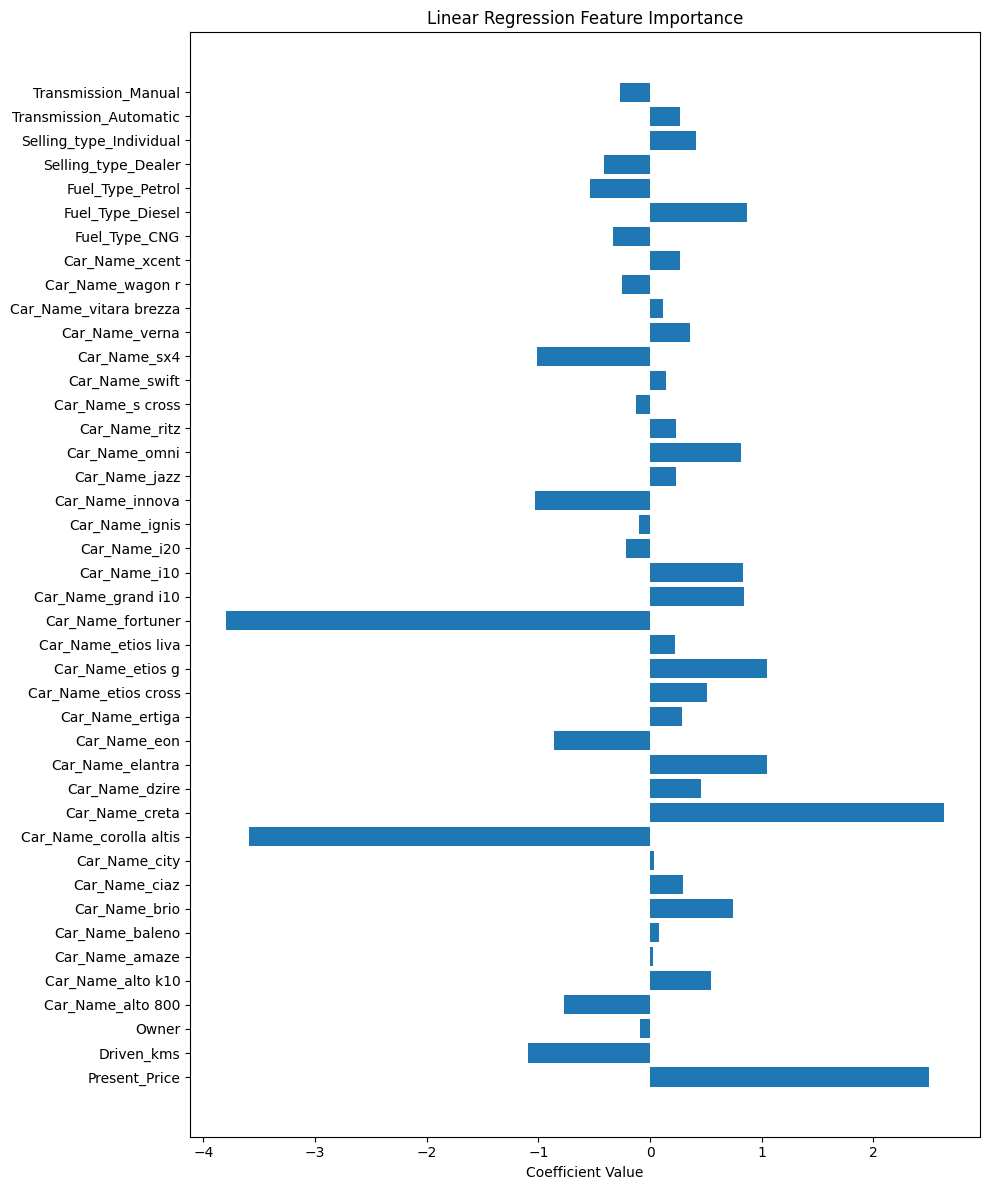

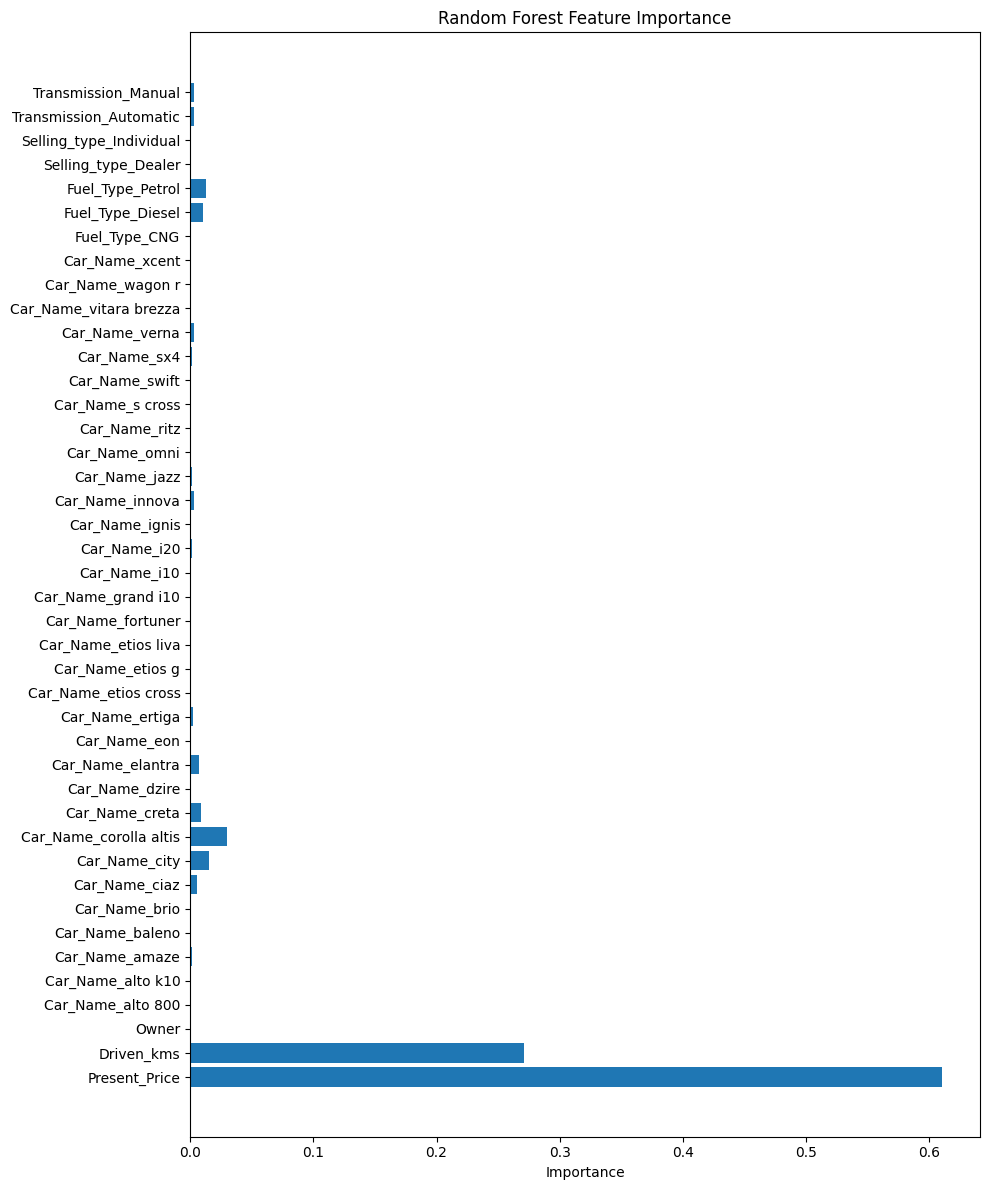

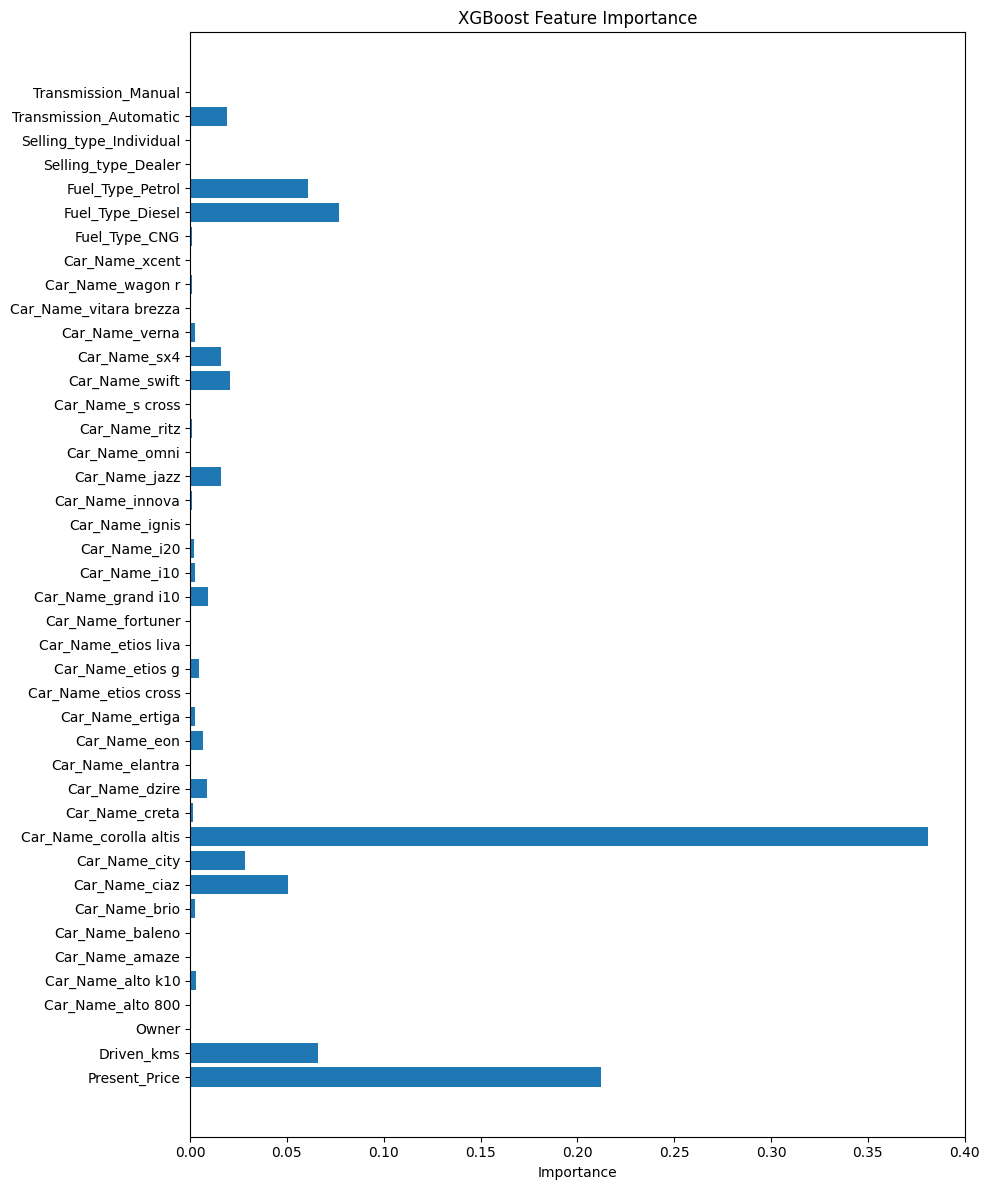

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def get_feature_names(preprocessor, X):
    """Get feature names after preprocessing (numerical + one-hot encoded categorical)"""
    num_features = preprocessor.transformers_[0][2]
    cat_features = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(preprocessor.transformers_[1][2])
    return np.concatenate([num_features, cat_features])

feature_names = get_feature_names(preprocessor, X)

# Linear Regression Feature Importance (coefficients)
lr_coef = lr_pipeline.named_steps['model'].coef_
plt.figure(figsize=(10,12))
plt.barh(feature_names, lr_coef)
plt.title("Linear Regression Feature Importance")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

# Random Forest Feature Importance
rf_importance = rf_pipeline.named_steps['model'].feature_importances_
plt.figure(figsize=(10,12))
plt.barh(feature_names, rf_importance)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# XGBoost Feature Importance
xgb_importance = xgb_model.named_steps['model'].feature_importances_
plt.figure(figsize=(10,12))
plt.barh(feature_names, xgb_importance)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()